# Human-intepretable Machine Learning - The road to Explainable AI

We will be working on a real-world dataset on Census income, also known as the Adult dataset available in the UCI ML Repository where we will be predicting if the potential income of people is more than $50K/yr or not.

_Tutorial by [Dipanjan (DJ) Sarkar](https://www.linkedin.com/in/dipanzan/)_

# Load necessary dependencies

In [1]:
import pandas as pd
import numpy as np
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
from collections import Counter
import shap
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

# Load the Census Income Dataset

In [2]:
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])
data.shape, labels.shape

((32561, 12), (32561,))

# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


| Attribute Name | Type | Description |
|-----------------------|----------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Age | Continuous | Represents age of the person |
| Workclass | Categorical | Represents the nature of working class\category<br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked) |
| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
| Occupation | Categorical | Represents the type of profession\job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
| Capital Gain | Continuous | The total capital gain for the person |
| Capital Loss | Continuous | The total capital loss for the person |
| Hours per week | Continuous | Total hours spent working per week |
| Country | Categorical | The country where the person is residing |
| Income Label (labels) | Categorical  (class label) | The class label column is the one we want to predict<br>(False: Income <= \$50K & True: Income > \$50K) |                                                                                                                                                                |

We have a total of 12 features and our objective is to predict if the income of a person will be more than \$50K (True) or less than \$50K (False). Hence we will be building and interpreting a classification model

In [3]:
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null category
Education-Num     32561 non-null float32
Marital Status    32561 non-null category
Occupation        32561 non-null category
Relationship      32561 non-null category
Race              32561 non-null category
Sex               32561 non-null category
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null category
dtypes: category(7), float32(5)
memory usage: 862.2 KB


# Basic Feature Engineering
Here we convert the categorical columns with string values to numeric representations. 
Typically the XGBoost model can handle categorical data natively being a tree-based model so we don't one-hot encode the features

In [5]:
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


## Viewing distribution of people with <=  \$50K (False) and > \$50K (True) income

In [6]:
Counter(labels)

Counter({0: 24720, 1: 7841})

# Building Train and Test Datasets

For any machine learning model, we always need train and test datasets. We will be building the model on the train dataset and test the performance on the test dataset. We maintain two datasets (one with the encoded categorical values and one with the original values) so we can train with the encoded dataset but use the original dataset as needed later on for model interpretation. 

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((22792, 12), (9769, 12))

In [8]:
X_train.head(3)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,6,9.0,2,5,5,4,0,0.0,2179.0,12.0,39
1216,48.0,6,10.0,2,3,0,0,1,7688.0,0.0,40.0,39
27962,23.0,7,10.0,2,10,0,4,1,0.0,0.0,30.0,39


In [9]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)
X_train_disp.shape, X_test_disp.shape

((22792, 12), (9769, 12))

In [10]:
X_train_disp.head(3)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,Self-emp-not-inc,9.0,Married-civ-spouse,Farming-fishing,Wife,White,Female,0.0,2179.0,12.0,United-States
1216,48.0,Self-emp-not-inc,10.0,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,7688.0,0.0,40.0,United-States
27962,23.0,State-gov,10.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States


# Training the classification model

We will now train and build a basic boosting classification model on our training data using the popular [XGBoost](https://xgboost.readthedocs.io/en/latest/) 
framework, an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable 

In [11]:
%%time

import xgboost as xgb

xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

CPU times: user 7.03 s, sys: 121 ms, total: 7.15 s
Wall time: 7.17 s


# Making predictions on the test data

Here we do the usual, use the trained model to make predictions on the test dataset

In [12]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])

# Model Performance Evaluation

Time to put the model to the test! Let's evaluate how our model has performed with its predictions on the test data. 
We use my nifty `model_evaluation_utils` module for this which leverages `scikit-learn` internally to give us 
standard classification model evaluation metrics

In [13]:
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8712
Precision: 0.8671
Recall: 0.8712
F1 Score: 0.8681

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.76      0.67      0.71      2314

   micro avg       0.87      0.87      0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6972   483
        1        775  1539


# Default Model Interpretation Methods

By default it is difficult to gauge on specific model interpretation methods for machine learning models out of the box. 
Parametric models like logistic regression are easier to interpret given that the total number of parameters of the model
are fixed regardless of the volume of data and one can make some interpretation of the model's prediction decisions leveraging
the parameter coefficients.

Non-parametric models are harder to interpret given that the total number of parameters remain unbounded and increase
with the increase in the data volume. Some non-parametric models like tree-based models do have some out of the box model 
interpretation methods like feature importance which helps us in understanding which features might be influential in
the model making its prediction decisions

## Classic feature importances from XGBoost

Here we try out the global feature importance calcuations that come with XGBoost. The model enables us to view feature importances based on the following.

- __Feature Weights:__ This is based on the number of times a feature appears in a tree across the ensemble of trees
- __Gain:__ This is based on the average gain of splits which use the feature
- __Coverage:__ This is based on the average coverage (number of samples affected) of splits which use the feature

Note that they all contradict each other, which motivates the use of model interpretation frameworks like SHAP which uses something known as SHAP values, which claim to come with consistency guarantees (meaning they will typically order the features correctly).

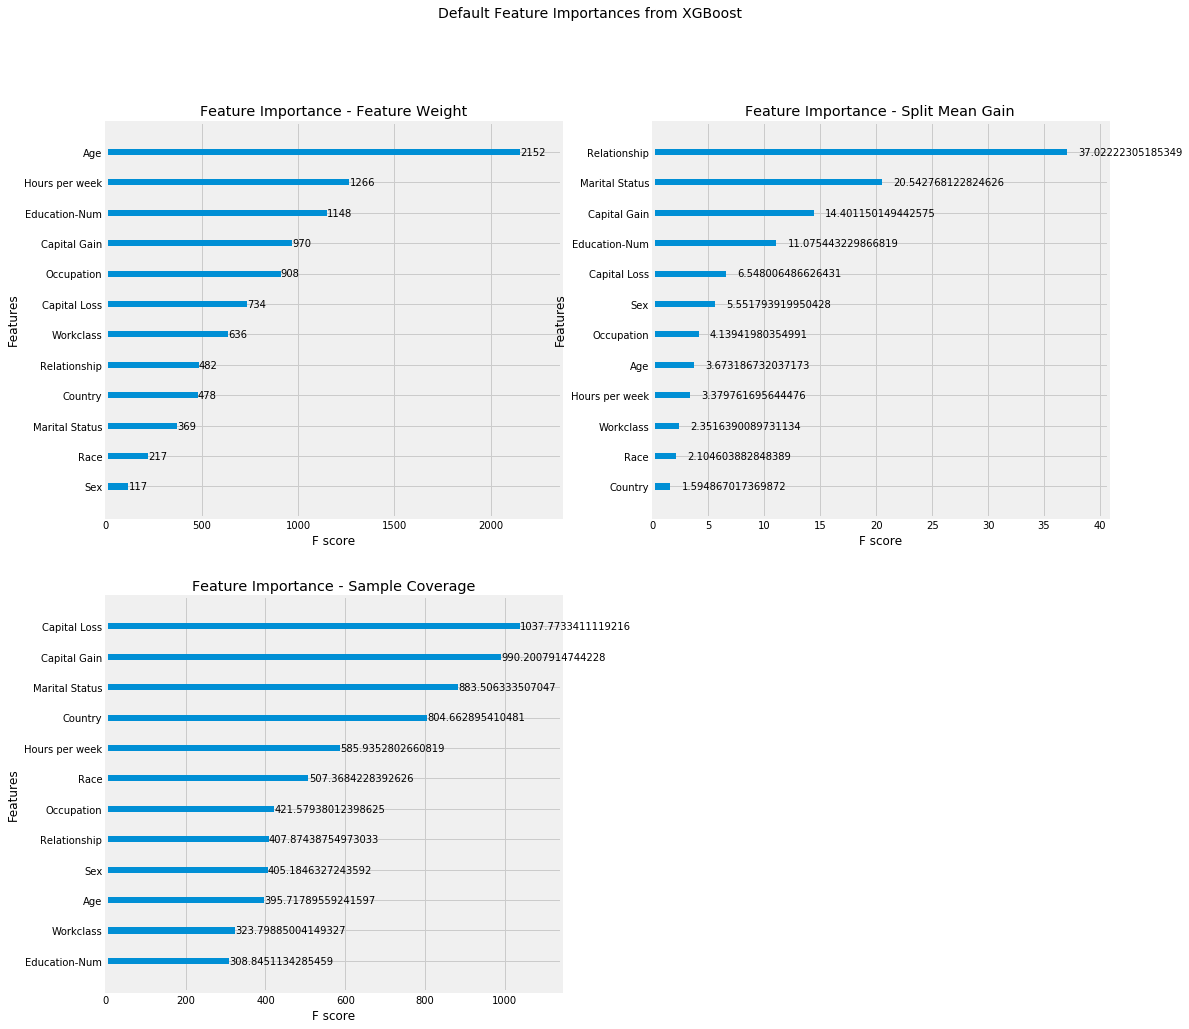

In [16]:
fig = plt.figure(figsize = (16, 16))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

# Model Interpretation with SHAP

**SHAP (SHapley Additive exPlanations)** is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on what they claim! (do check out the [SHAP NIPS paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for details).



### Install

SHAP can be installed from [PyPI](https://pypi.org/project/shap)

```
pip install shap
```

or [conda-forge](https://anaconda.org/conda-forge/shap)

```
conda install -c conda-forge shap 
```

The really awesome aspect about this framework is while SHAP values can explain the output of any machine learning model, for really complex ensemble models it can be slow. But they have developed a high-speed exact algorithm for tree ensemble methods ([Tree SHAP arXiv paper](https://arxiv.org/abs/1802.03888)). Fast C++ implementations are supported for *XGBoost*, *LightGBM*, *CatBoost*, and *scikit-learn* tree models!

SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction. Its novel components include: the identification of a new class of additive feature importance measures, and theoretical results showing there is a unique solution in this class with a set of desirable properties. Typically, SHAP values try to explain the output of a model (function) as a sum of the effects of each feature being introduced into a conditional expectation. Importantly, for non-linear functions the order in which features are introduced matters. The SHAP values result from averaging over all possible orderings. Proofs from game theory show this is the only possible consistent approach. 

An intuitive way to understand the Shapley value is the following: The feature values enter a room in random order. All feature values in the room participate in the game (= contribute to the prediction). The Shapley value __$ϕ_{ij}$__ is the average marginal contribution of feature value __$x_{ij}$__ by joining whatever features already entered the room before, i.e.

$$\phi_{ij}=\sum_{\text{All.orderings}}val(\{\text{features.before.j}\}\cup{}x_{ij})-val(\{\text{features.before.j}\})$$

The following figure from the KDD 18 paper, [_Consistent Individualized Feature Attribution for Tree Ensembles_](https://arxiv.org/pdf/1802.03888.pdf) summarizes this in a nice way!

![](https://i.imgur.com/6Rc1dsa.png)

Let's now dive into SHAP and leverage it for interpreting our model!

## Explain predictions with SHAP

학습된 XBBoost 모델에 X_test 값에 대한 Tree SHAP 구현을 활용

In [17]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)

In [18]:
pd.DataFrame(shap_values).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.209206,-0.003895,-0.073927,-1.078541,-0.645259,-0.517731,-0.002871,-0.421329,-0.144742,-0.036394,-0.568053,-0.004587
1,0.354368,-0.262398,-0.483883,0.586233,0.307967,1.194750,0.017408,-0.216272,-0.108322,-0.048158,-0.095782,0.017657
2,-0.525650,0.030637,0.970991,0.360480,0.528695,0.603971,-0.103895,0.050630,-0.176231,-0.087669,0.509656,0.024573
3,-0.426094,0.076188,0.576406,-1.108961,-0.517884,-0.522604,0.028896,-0.359869,-0.142805,-0.057430,-0.250737,0.023183
4,-0.503867,-0.159754,-0.129339,-0.547773,-0.049194,-0.414065,-0.019701,0.128197,-3.685364,-0.031033,0.781617,0.001285


This returns a matrix of SHAP values (`# samples x # features`). Each row sums to the difference between the model output for that sample and the expected value of the model output (which is stored as `expected_value` attribute of the explainer). Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome.

In [19]:
print('Expected Value:', explainer.expected_value)

Expected Value: -1.3625857


### Predicting when a person's income <= \$50K 

SHAP gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as below \$50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [39]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test_disp.iloc[1,:])

### Predicting when a person's income > \$50K 

Similarly, SHAP gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as greater than \$50K.

In [22]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_disp.iloc[2,:])

## Visualizing and explaining multiple predictions

One of the key advantages of SHAP is it can build beautiful interactive plots which can visualize and explain multiple predictions at once. Here we visualize model prediction decisions for the first 1000 test data samples.

In [42]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test_disp.iloc[:1000,:])

The above visualization can be interacted with in multiple ways. The default visualization shows some interesting model prediction pattern decisions.

- The first 100 test samples all probably __earn more than \$50K__ and they __are married__ or\and have a __good capital gain__ or\and have a __higher education level__!
- The next 170+ test samples all probably __earn less than or equal to \$50K__ and they __are mostly un-married__ and\or are __very young in age or divorced__!
- The next 310+ test samples have an inclination towards mostly __earning more than \$50K__ and they are of diverse profiles including married folks, people with different age and education levels and occupation. Most dominant features pushing the model towards making a prediction for higher income is the person being married i.e. __relationship: husband or wife__!
- The remaining 400+ test samples have an inclination towards mostly __earning less than \$50K__ and they are of diverse profiles however dominant patterns include __relationship: either unmarried or divorced__ and __very young in age__! 

Definitely interesting how we can find out patterns which lead to the model making specific decisions and being able to provide explanations for them.

## Feature Importances with SHAP

This basically takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

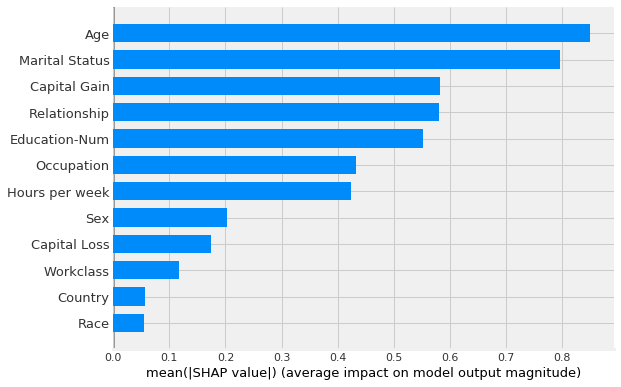

In [26]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## SHAP Summary Plot

Besides a typical feature importance bar chart, SHAP also enables us to use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the age and marital status feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age or marital status. In other words, capital gain effects a few predictions by a large amount, while age or marital status effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

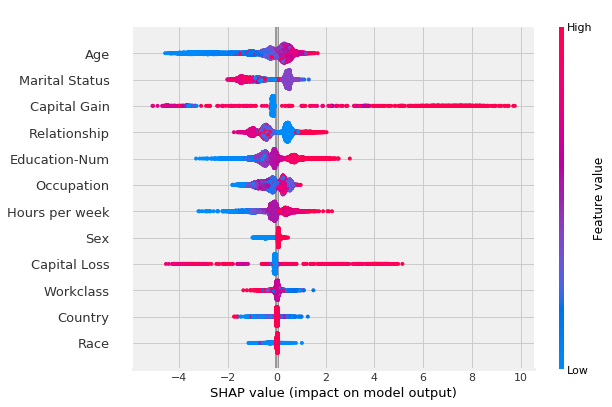

In [27]:
shap.summary_plot(shap_values, X_test)

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single (or two) feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature can be chosen for coloring to highlight possible interactions.

You will also notice it's similarity with Skater's Partial Dependence Plots!

### PDP of 'Age' affecting model prediction

Just like we observed before. the middle-aged people have a slightly higher shap value, pushing the model's prediction decisions to say that these individuals make more money as compared to younger or older people

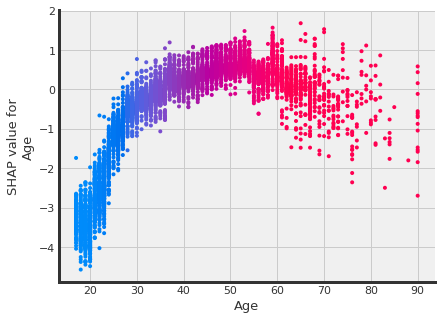

In [28]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### PDP of 'Education-Num' affecting model prediction

Higher education levels have higher shap values, pushing the model's prediction decisions to say that these individuals make more money as compared to people with lower education levels

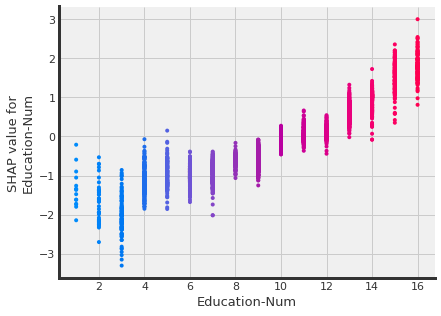

In [29]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### PDP of 'Relationship' affecting model prediction

Just like we observed during the model prediction explanations, married people (husband or wife) have a slightly higher shap value, pushing the model's prediction decisions to say that these individuals make more money as compared to other folks!

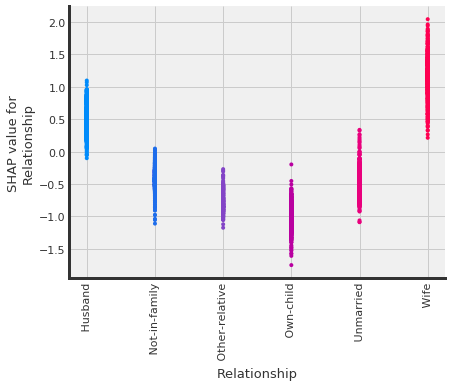

In [30]:
shap.dependence_plot(ind='Relationship', interaction_index='Relationship',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### PDP of 'Capital Gain' affecting model prediction

You might have observed a very similar plot in the Skater PDPs, here typically a Capital Gain of more than \$5K - \$8K leads to a huge spike in the SHAP values making the model push towards prediction decisions to say that these individuals make more money as compared to others!

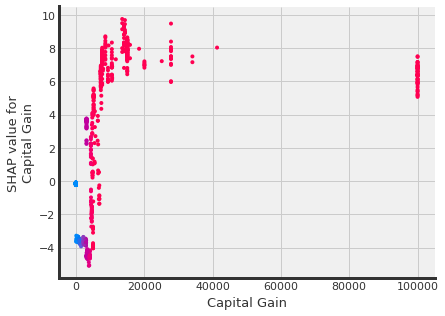

In [31]:
shap.dependence_plot(ind='Capital Gain', interaction_index='Capital Gain',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### Two-way PDP showing interactions between features 'Age' and 'Capital Gain' and their effect on making more than \$50K

The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions. Here we are trying to see interactions between `Age` and `Capital Gain`and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

Interesting to see higher the higher capital gain and the middle-aged folks (30-50) having the highest chance of making more money!

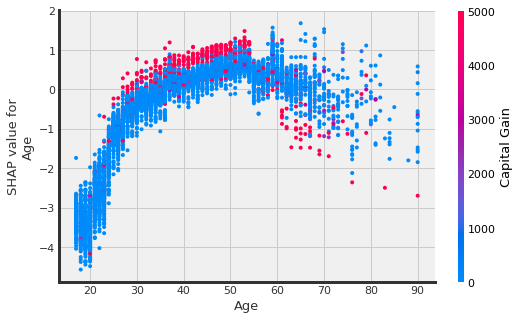

In [32]:
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

### Two-way PDP showing interactions between features 'Education-Num' and 'Relationship' and their effect on making more than \$50K

Here we are trying to see interactions between `Education-Num` and `Relationship`and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

Interesting to see higher the higher education level and the husband or wife (married) folks having the highest chance of making more money!

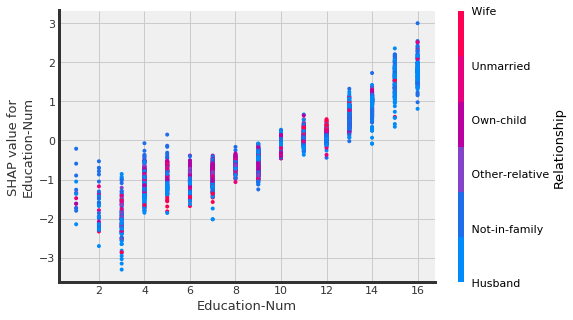

In [33]:
shap.dependence_plot(ind='Education-Num', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

### Two-way PDP showing interactions between features 'Marital Status' and 'Relationship' and their effect on making more than \$50K

Here we are trying to see interactions between `Marital Status` and `RElationship`and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

This is interesting because both the features are similar in some context, we can see typically married people with relationship status of either husband or wife having the highest chance of making more money!

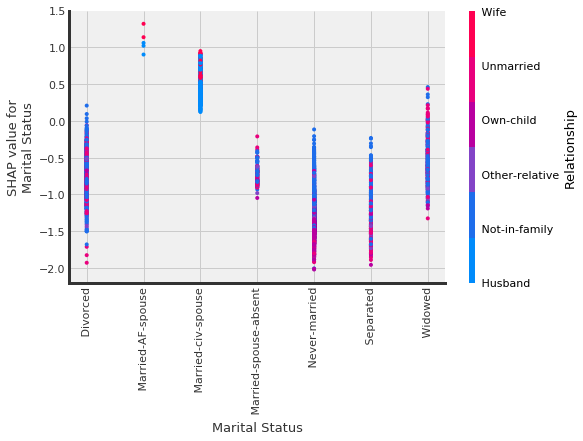

In [34]:
shap.dependence_plot(ind='Marital Status', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

### Two-way PDP showing interactions between features 'Age' and 'Hours per week' and their effect on making more than \$50K

Here we are trying to see interactions between `Age` and `Hours per week`and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

Nothing extra-ordinary here, middle-aged people working the most make the most money!

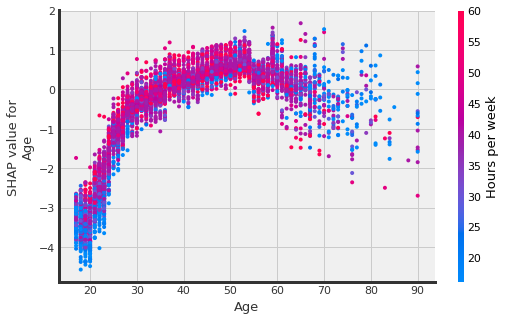

In [35]:
shap.dependence_plot(ind='Age', interaction_index='Hours per week', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

# Final Words

If you are reading this, I would like to really commend your efforts on going through this comprehensive tutorial on machine learning model interpretation and encourage you to try out some of these frameworks with your own models and datasets and explore the world of model interpretation!